# Preparation

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore
import numpy as np

In [2]:
# Base df
df = pd.read_csv('../data/z_df_ready_for_analysis.csv')

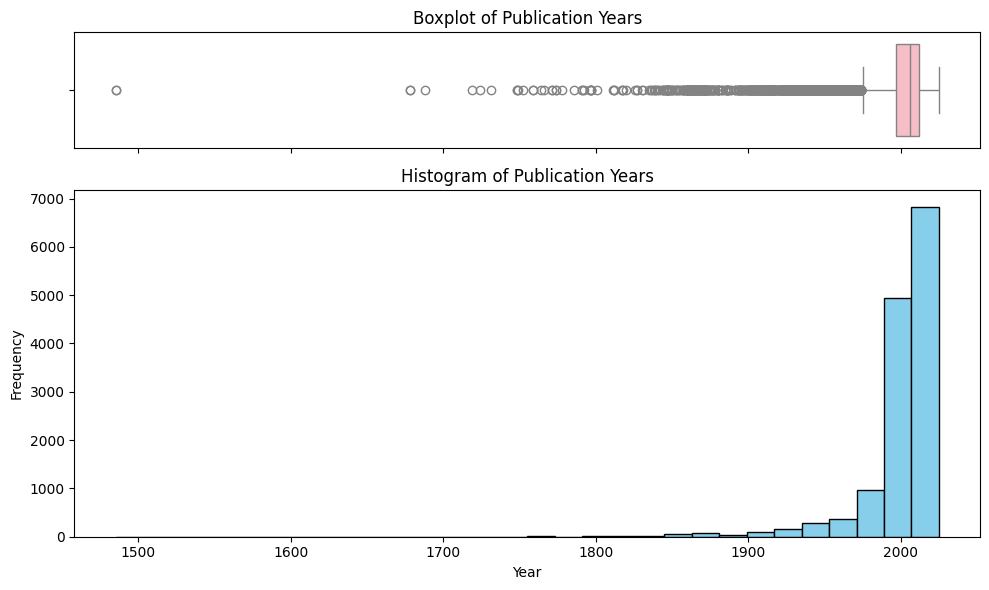

In [3]:
# Plot year outliers

fig, (ax_box, ax_hist) = plt.subplots(
    nrows=2, 
    sharex=True, 
    figsize=(10, 6), 
    gridspec_kw={"height_ratios": (1, 3)}
)

# Boxplot on top
sns.boxplot(x=df['year'], ax=ax_box, color='lightpink')
ax_box.set(title='Boxplot of Publication Years')
ax_box.set(xlabel='')

# Histogram below
ax_hist.hist(df['year'], bins=30, edgecolor='black', color='skyblue')
ax_hist.set(title='Histogram of Publication Years', xlabel='Year', ylabel='Frequency')

plt.tight_layout()
plt.show()

In [4]:
# # df exluding year outliers

# # Step 1: Compute Q1, Q3, and IQR
# Q1 = df['year'].quantile(0.25)
# Q3 = df['year'].quantile(0.75)
# IQR = Q3 - Q1

# # Step 2: Define outlier thresholds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Step 3: Filter the outlier rows
# outlier_years = df[(df['year'] < lower_bound) | (df['year'] > upper_bound)]['year'].unique()

# # Step 4: Keep only rows where 'year' is NOT an outlier
# df_no_o = df[(df['year'] >= lower_bound) & (df['year'] <= upper_bound)].copy()

In [6]:
# Make sure gender is a categorical variable with the desired order for plotting
# Base df
df['author_gender'] = pd.Categorical(
    df['author_gender'].replace({0: 'Male', 1: 'Female'}),
    categories=['Male', 'Female'],
    ordered=True
)

# # No outliers df
# df_no_o['author_gender'] = pd.Categorical(
#     df_no_o['author_gender'].replace({0: 'Male', 1: 'Female'}),
#     categories=['Male', 'Female'],
#     ordered=True
# )

# Check Assumptions for MLR
## Linearity

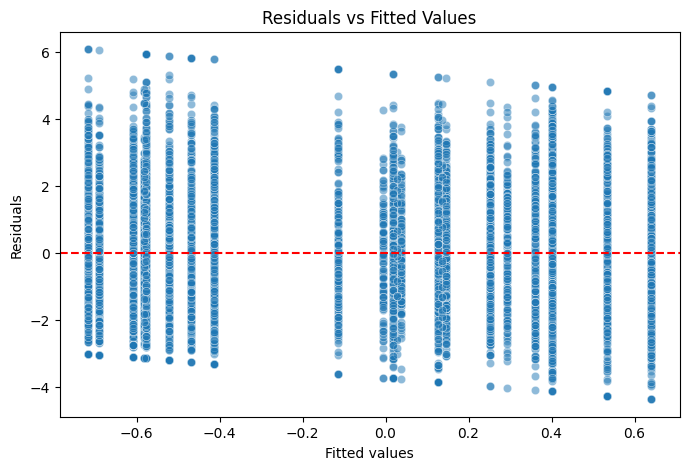

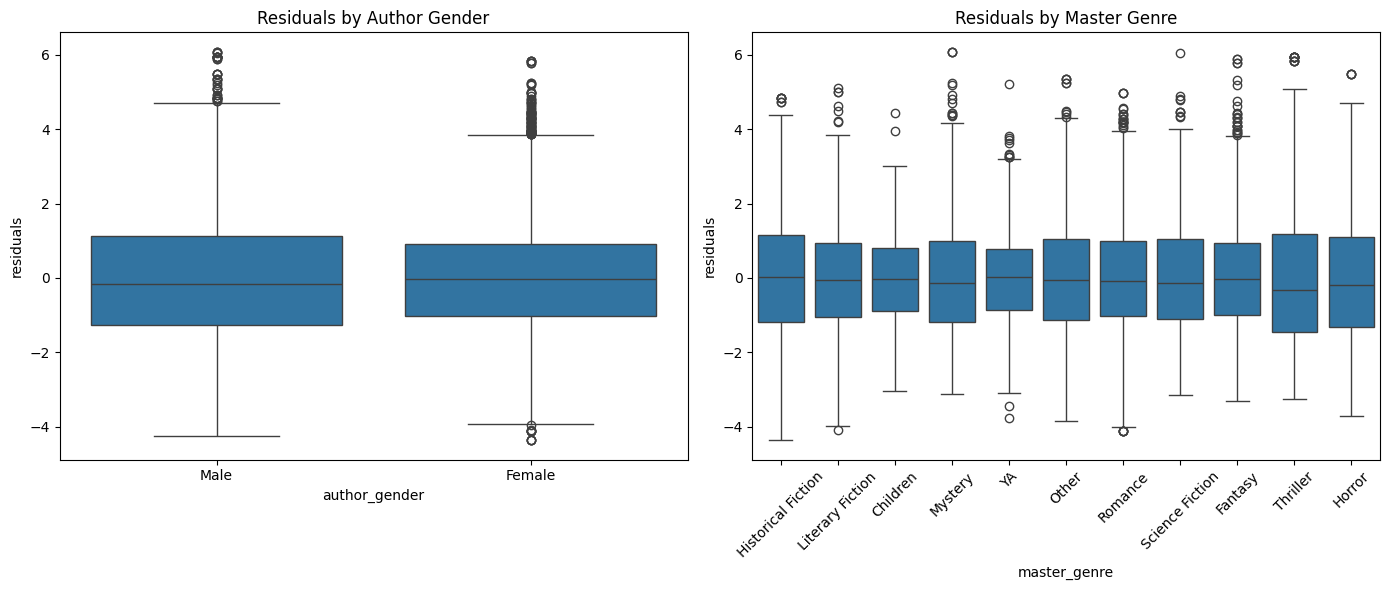

In [9]:
# Fit model
model = smf.ols('z_diff_prop ~ C(author_gender) + C(master_genre)', data=df).fit()

# Get residuals and fitted values
df['residuals'] = model.resid
df['fitted'] = model.fittedvalues

# 1. Residuals vs Fitted values plot (should be random scatter)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='fitted', y='residuals', data=df, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# 2. Residuals by category plots

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='author_gender', y='residuals', data=df)
plt.title('Residuals by Author Gender')

plt.subplot(1, 2, 2)
sns.boxplot(x='master_genre', y='residuals', data=df)
plt.title('Residuals by Master Genre')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


* Residuals vs Fitted plot: No pattern (no curve or funnel shape) means good linearity.
* Boxplots of residuals by category: Medians should be near zero and roughly similar spreads.

## Independence of errors

In [10]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_stat:.3f}')


Durbin-Watson statistic: 1.945


Around 2.0 → Residuals are independent (ideal)  
Closer to 0 → Positive autocorrelation (bad)  
Closer to 4 → Negative autocorrelation (also bad)  

## Homoscedasticity
* see Residuals vs. Fitted Values plot

## Multicollinearity

In [11]:
X = model.model.exog  # gets the design matrix
feature_names = model.model.exog_names

vif_data = pd.DataFrame()
vif_data["feature"] = feature_names
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif_data)


                                  feature        VIF
0                               Intercept  49.206397
1              C(author_gender)[T.Female]   1.164747
2              C(master_genre)[T.Fantasy]   6.843944
3   C(master_genre)[T.Historical Fiction]   5.049184
4               C(master_genre)[T.Horror]   2.098190
5     C(master_genre)[T.Literary Fiction]   5.087584
6              C(master_genre)[T.Mystery]   4.778303
7                C(master_genre)[T.Other]   4.423931
8              C(master_genre)[T.Romance]   8.688538
9      C(master_genre)[T.Science Fiction]   3.187410
10            C(master_genre)[T.Thriller]   3.848429
11                  C(master_genre)[T.YA]   4.073848


# Descriptives
## Standardized Means 
### General

In [12]:
df[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()

,z_prop_pos,z_prop_neg,z_diff_prop
count,1.386900e+04,1.386900e+04,1.386900e+04
mean,1.352536e-16,-6.352823e-17,2.131270e-16
std,1.000036e+00,1.000036e+00,1.632462e+00
min,-1.733324e+00,-2.002652e+00,-3.726654e+00
25%,-7.145819e-01,-7.731193e-01,-1.150515e+00
50%,-3.542010e-02,-4.661141e-03,-3.407555e-02
75%,6.176201e-01,7.637970e-01,1.045082e+00
max,3.360389e+00,1.993330e+00,5.363041e+00


In [13]:
# df_no_o[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()

### by Author Gender

In [14]:
df.groupby('author_gender')[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()

/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_1524/1455878219.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('author_gender')[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()


z_prop_pos                                                    \
                   count      mean       std       min       25%       50%   
author_gender                                                                
Male              4204.0 -0.136796  1.061596 -1.733324 -0.949676 -0.166028   
Female            9665.0  0.059502  0.966073 -1.733324 -0.557852 -0.035420   

                                 z_prop_neg            ...                     \
                   75%       max      count      mean  ...       75%      max   
author_gender                                          ...                      
Male           0.61762  3.360389     4204.0  0.057562  ...  0.994334  1.99333   
Female         0.61762  3.360389     9665.0 -0.025038  ...  0.661336  1.99333   

              z_diff_prop                                                    \
                    count      mean       std       min       25%       50%   
author_gender                                                                 
Male               4204.0 -0.194359  1.808203 -3.726654 -1.490531 -0.315059   
Female             9665.0  0.084540  1.542287 -3.726654 -0.989507  0.054758   

                                   
                    75%       max  
author_gender                      
Male           0.998915  5.363041  
Female         1.080116  5.363041  

[2 rows x 24 columns]

In [15]:
# df_no_o.groupby('author_gender')[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()

# Regressions

## Total (Difference in Standardized Proportions)
### Year Outliers Included

In [16]:
# Regression Coefficients 
model = smf.ols('z_diff_prop ~ author_gender + master_genre', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            z_diff_prop   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     100.5
Date:                Wed, 30 Jul 2025   Prob (F-statistic):          3.94e-221
Time:                        11:55:16   Log-Likelihood:                -25944.
No. Observations:               13869   AIC:                         5.191e+04
Df Residuals:                   13857   BIC:                         5.200e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [17]:
# Regression Coefficients with interaction and year
model = smf.ols('z_diff_prop ~ author_gender + master_genre + author_gender*master_genre + year', data=df).fit()
print(model.summary())

# -> year significant (negative)

                            OLS Regression Results                            
Dep. Variable:            z_diff_prop   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     59.05
Date:                Wed, 30 Jul 2025   Prob (F-statistic):          3.49e-249
Time:                        11:56:33   Log-Likelihood:                -25854.
No. Observations:               13869   AIC:                         5.175e+04
Df Residuals:                   13846   BIC:                         5.193e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [18]:
# ANOVA for easier reporting of categorical predictor results
# Without interaction -> ag and g significant
model_me = smf.ols('z_diff_prop ~ C(author_gender) + C(master_genre)', data=df).fit()
anova_model_me = anova_lm(model_me, typ=3)
print(anova_model_me)

                        sum_sq       df           F         PR(>F)
Intercept             0.232817      1.0    0.094256   7.588396e-01
C(author_gender)     29.322407      1.0   11.871137   5.717952e-04
C(master_genre)    2501.783718     10.0  101.284376  1.120967e-203
Residual          34227.605747  13857.0         NaN            NaN


In [18]:
# ANOVA for easier reporting of categorical predictor results
# Effect Sizes
anova = pg.anova(
    data=df,
    dv='z_diff_prop',
    between=['author_gender', 'master_genre'],
    detailed=True
)

print(anova)

# Effect size author gender: 0.000860 -> not even small
# Effect size genre: 0.068436 -> medium
# Effect size author gender*genre: 0.005042 -> small

                         Source            SS       DF          MS  \
0                 author_gender     29.322407      1.0   29.322407   
1                  master_genre   2501.783718     10.0  250.178372   
2  author_gender * master_genre    172.580206     10.0   17.258021   
3                      Residual  34055.025541  13847.0    2.459379   

            F          p-unc       np2  
0   11.922686   5.562023e-04  0.000860  
1  101.724191  1.485835e-204  0.068436  
2    7.017226   4.403798e-11  0.005042  
3         NaN            NaN       NaN  


In [19]:
# ANOVA for easier reporting of categorical predictor results
# With interaction -> ag*g significant
model_me_i = smf.ols('z_diff_prop ~ C(author_gender) * C(master_genre)', data=df).fit()
anova_model_me_i = anova_lm(model_me_i, typ=3)
print(anova_model_me_i)



                                        sum_sq       df          F  \
Intercept                             4.721091      1.0   1.919627   
C(author_gender)                     11.207324      1.0   4.556972   
C(master_genre)                    1012.999142     10.0  41.189219   
C(author_gender):C(master_genre)    172.580206     10.0   7.017226   
Residual                          34055.025541  13847.0        NaN   

                                        PR(>F)  
Intercept                         1.659201e-01  
C(author_gender)                  3.280249e-02  
C(master_genre)                   4.968027e-81  
C(author_gender):C(master_genre)  4.403798e-11  
Residual                                   NaN  


### Year Outliers NOT Included

In [21]:
# # Regression Coefficients 
# model = smf.ols('z_diff_prop ~ author_gender + master_genre + author_gender*master_genre + year', data=df_no_o).fit()
# print(model.summary())

# # -> year significant (negative) (but less)

In [23]:
# # Without interaction -> ag and g still significant
# model_me = smf.ols('z_diff_prop ~ C(author_gender) + C(master_genre)', data=df_no_o).fit()
# anova_model_me = anova_lm(model_me, typ=3)
# print(anova_model_me)

In [24]:
# # ANOVA for easier reporting of categorical predictor results
# # Effect Sizes
# anova = pg.anova(
#     data=df_no_o,
#     dv='z_diff_prop',
#     between=['author_gender', 'master_genre'],
#     detailed=True
# )

# print(anova)

# # Effect size author gender: 0.002987 -> not even small
# # Effect size genre: 0.065851 -> medium
# # Effect size author gender*genre: 0.005690 -> small
# # Effect sizes are the same with and without outliers

In [26]:
# # With interaction -> ag*g still significant
# model_me_i = smf.ols('z_diff_prop ~ C(author_gender) * C(master_genre)', data=df_no_o).fit()
# anova_model_me_i = anova_lm(model_me_i, typ=3)
# print(anova_model_me_i)

### Plots (with outliers only)

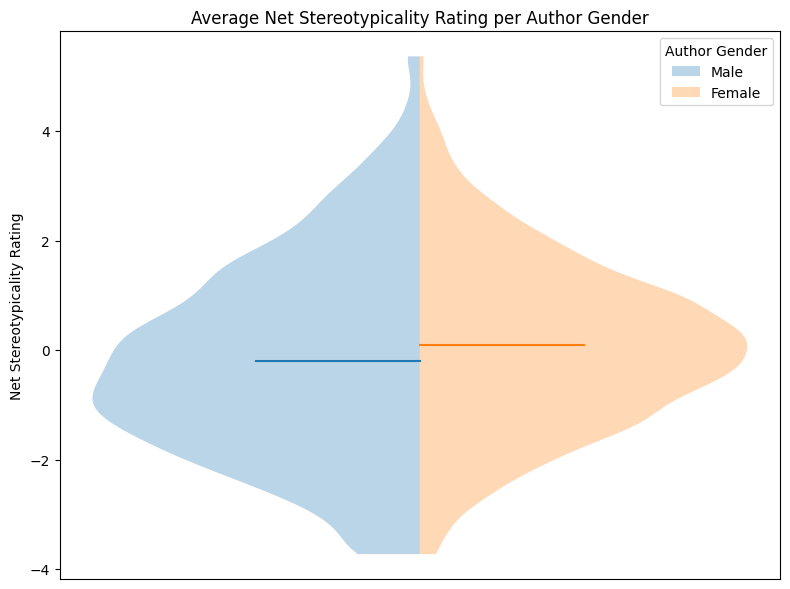

In [27]:
# Author Gender ME - Total - Plot
# Significance: C(author_gender)     29.322407      1.0   11.871137   5.717952e-04

# Extract groups
male_data = df[df['author_gender'] == 'Male']['z_diff_prop']
female_data = df[df['author_gender'] == 'Female']['z_diff_prop']

fig, ax = plt.subplots(figsize=(8, 6))

v1 = ax.violinplot(
    male_data,
    positions=[0],
    showmeans=True,
    showmedians=False,
    showextrema=False,
    side='low'
)

v2 = ax.violinplot(
    female_data,
    positions=[0],
    showmeans=True,
    showmedians=False,
    showextrema=False,
    side='high'
)

# Axis labels
ax.set_xticks([]) 
ax.set_xticklabels([])
ax.set_ylabel("Net Stereotypicality Rating")
ax.set_title("Average Net Stereotypicality Rating per Author Gender")

from matplotlib.patches import Patch

# Get actual colors from the violin objects
male_color = v1['bodies'][0].get_facecolor().flatten()
female_color = v2['bodies'][0].get_facecolor().flatten()

legend_elements = [
    Patch(facecolor=male_color, label='Male'),
    Patch(facecolor=female_color, label='Female')
]

ax.legend(handles=legend_elements, title='Author Gender')

plt.tight_layout()
plt.show()

In [28]:
# Author Gender ME - Total - Significance Test
tukey = pairwise_tukeyhsd(endog=df['z_diff_prop'],
                          groups=df['author_gender'],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper reject
-------------------------------------------------
Female   Male  -0.2789   0.0 -0.3378 -0.22   True
-------------------------------------------------


In [29]:
# Author Gender ME - Total - Effect size

# Subset the groups
group_male = df[df['author_gender'] == "Male"]['z_diff_prop']
group_female = df[df['author_gender'] == "Female"]['z_diff_prop']

# Calculate Cohen's d
d = pg.compute_effsize(group_female, group_male, eftype='cohen', paired=False)

print("Cohen's d:", d)


Cohen's d: 0.1713685941208073


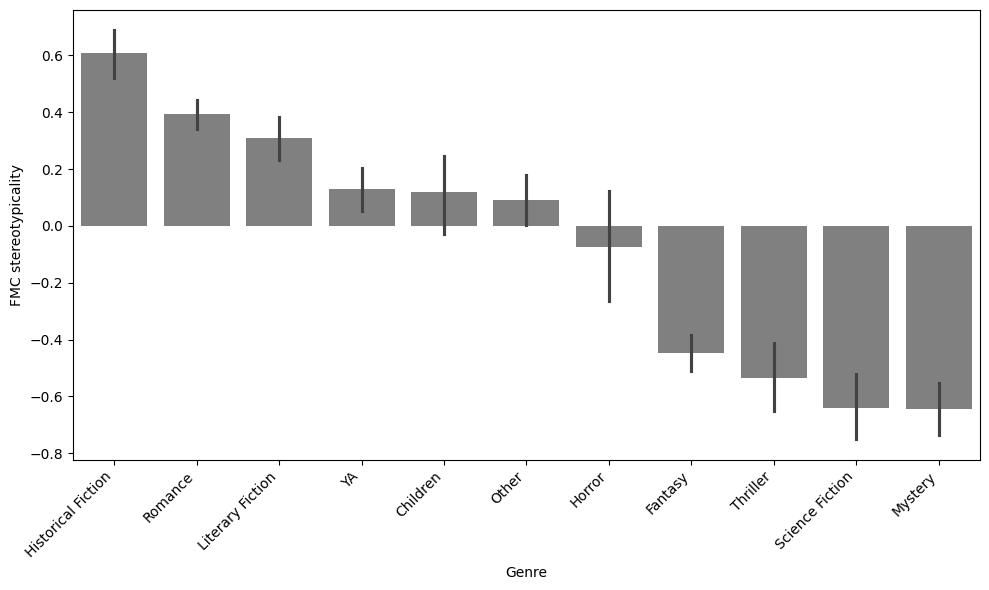

In [30]:
# Genre ME - Total - Plot
# Calculate means and confidence intervals per group
summary = df.groupby('master_genre')['z_diff_prop'].agg(['mean', 'count', 'std']).reset_index()
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# Sort genres by mean for consistent ordering
summary = summary.sort_values('mean', ascending=False)
order = summary['master_genre']

plt.figure(figsize=(10, 6))

# Plot bars with seaborn, ordered by 'order', using grayscale palette
barplot = sns.barplot(
    data=df, 
    x='master_genre', 
    y='z_diff_prop', 
    order=order, 
    errorbar=('ci', 95),
    color='gray'
)

# Map bar colors to genres
bar_colors = {}
for patch in barplot.patches:
    # x coordinate is the bar index
    x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
    bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# Draw horizontal mean lines and two dashed lines for CI bounds
for _, row in summary.iterrows():
    genre = row['master_genre']
    mean = row['mean']
    ci = row['ci95']
    color = bar_colors[genre]
    
    # # Lower CI bound dashed line
    # plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
    # # Upper CI bound dashed line
    # plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
plt.ylabel("FMC stereotypicality")
plt.xlabel("Genre")
plt.tight_layout()
plt.savefig('../visualizations/Figure 3.png', dpi=300)
plt.show()

In [31]:
# ONLINE SUPPLEMENT ONLY
# Genre ME - Total - Significance Test 

# -- Which genres are significantly different from each other? --

# Drop NA values to avoid errors
df_clean = df[['master_genre', 'z_diff_prop']].dropna()

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_diff_prop'],
                          groups=df_clean['master_genre'],
                          alpha=0.05)

print(tukey.summary())

# Convert Tukey results to a DataFrame
tukey_results = pd.DataFrame(
    data=tukey._results_table.data[1:],  # Skip header
    columns=tukey._results_table.data[0]  # Column names
)

tukey_results.to_latex('tukey_results.tex', index=False)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
          Children            Fantasy  -0.5666    0.0 -0.8762  -0.257   True
          Children Historical Fiction   0.4905    0.0  0.1708  0.8102   True
          Children             Horror  -0.1931 0.8992 -0.5917  0.2056  False
          Children   Literary Fiction   0.1906  0.705 -0.1291  0.5102  False
          Children            Mystery  -0.7613    0.0 -1.0833 -0.4393   True
          Children              Other  -0.0261    1.0 -0.3516  0.2995  False
          Children            Romance   0.2759 0.1154 -0.0278  0.5796  False
          Children    Science Fiction  -0.7588    0.0 -1.1054 -0.4121   True
          Children           Thriller  -0.6535    0.0 -0.9875 -0.3196   True
          Children                 YA   0.0111    1.0 -0.3186  0.3407  False

Genre: Historical Fiction
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
Female   Male   0.0113 0.9077 -0.1799 0.2025  False
---------------------------------------------------
Genre: Romance
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
Female   Male   0.0777 0.4745 -0.1353 0.2907  False
---------------------------------------------------
Genre: Literary Fiction
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
Female   Male  -0.0108 0.8901 -0.1644 0.1427  False
---------------------------------------------------
Genre: YA
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
-----------------------------------------

/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_1524/4171822524.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = genre_data.groupby('author_gender')['z_diff_prop'].mean()


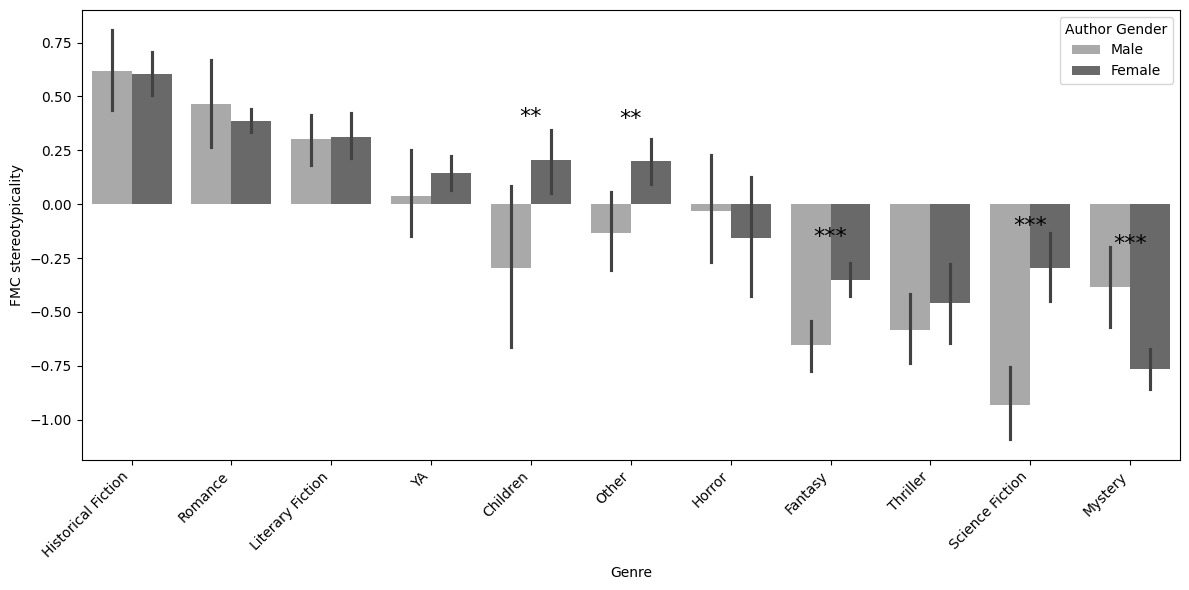

In [35]:
order = df.groupby('master_genre')['z_diff_prop'].mean().sort_values(ascending=False).index
gray_colors = ["#A9A9A9", "#696969"]  # light and dark gray

#significance test within genres
for genre in order:
    print(f"Genre: {genre}")
    genre_data = df[df['master_genre'] == genre]
    
    # Perform Tukey HSD
    tukey = pairwise_tukeyhsd(endog=genre_data['z_diff_prop'],
                              groups=genre_data['author_gender'],
                              alpha=0.05)
    print(tukey)


plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df,
    x='master_genre',
    y='z_diff_prop',
    hue='author_gender',
    palette=gray_colors,
    errorbar=('ci', 95),
    order=order
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("FMC stereotypicality")
plt.xlabel("Genre")
plt.legend(title="Author Gender")
plt.tight_layout()


# Add significance stars for gender difference within each genre
for i, genre in enumerate(order):
    genre_data = df[df['master_genre'] == genre]
    tukey = pairwise_tukeyhsd(endog=genre_data['z_diff_prop'],
                              groups=genre_data['author_gender'],
                              alpha=0.05)
    # Get p-value for Male vs Female
    try:
        pval = tukey.pvalues[0]
    except Exception:
        pval = np.nan
    # Determine number of stars
    if pval < 0.001:
        stars = '***'
    elif pval < 0.01:
        stars = '**'
    elif pval < 0.05:
        stars = '*'
    else:
        stars = ''
    # Get bar heights for annotation
    means = genre_data.groupby('author_gender')['z_diff_prop'].mean()
    y_max = means.max()
    # Annotate above the bars
    ax.text(i, y_max + 0.15, stars, ha='center', va='bottom', fontsize=16, color='black')
plt.savefig('../visualizations/Figure 4.png', dpi=300)
plt.show()



In [ ]:
# ONLINE SUPPLEMENT ONLY
# Interaction - Total - Significance Test

df_clean = df[['master_genre', 'author_gender', 'z_diff_prop']].dropna()

# Create interaction column
df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# Run Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_diff_prop'],
                          groups=df_clean['interaction'],
                          alpha=0.05)

print(tukey.summary())

# Convert Tukey results to a DataFrame
tukey_results = pd.DataFrame(
    data=tukey._results_table.data[1:],  # Skip header
    columns=tukey._results_table.data[0]  # Column names
)
tukey_results.to_latex('tukey_results.tex', index=False)

In [38]:
# # Author Gender * Genre - Total - Effect size - Fantasy

# # Subset the groups
# group_female_fantasy = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Fantasy")]['z_diff_prop']
# group_male_fantasy = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Fantasy")]['z_diff_prop']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female_fantasy, group_male_fantasy, eftype='cohen', paired=False)

# print("Cohen's d for Female vs Male Fantasy:", d)

In [37]:
# # Author Gender * Genre - Total - Effect size - Science Fiction

# # Subset the groups
# group_female_scifi = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Science Fiction")]['z_diff_prop']
# group_male_scifi = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Science Fiction")]['z_diff_prop']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female_scifi, group_male_scifi, eftype='cohen', paired=False)

# print("Cohen's d for Female vs Male Science Fiction:", d)

In [39]:
# # Author Gender * Genre - Total - Effect size - Mystery

# # Subset the groups
# group_female_mystery = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Mystery")]['z_diff_prop']
# group_male_mystery = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Mystery")]['z_diff_prop']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female_mystery, group_male_mystery, eftype='cohen', paired=False)

# print("Cohen's d for Female vs Male Mystery:", d)

## Standardized Pro-Stereotypical Items
### Year Outliers Included

In [40]:
# # Regression Coefficients 
# model = smf.ols('z_prop_pos ~ author_gender + master_genre + author_gender*master_genre + year', data=df).fit()
# print(model.summary())

# # -> year significant (negative)

In [41]:
# # Without interaction -> ag and g significant
# model_me = smf.ols('z_prop_pos ~ C(author_gender) + C(master_genre)', data=df).fit()
# anova_model_me = anova_lm(model_me, typ=3)
# print(anova_model_me)

In [42]:
# # ANOVA for easier reporting of categorical predictor results
# # Effect Sizes
# anova = pg.anova(
#     data=df,
#     dv='z_prop_pos',
#     between=['author_gender', 'master_genre'],
#     detailed=True
# )

# print(anova)

# # Effect size author gender: 0.003483 -> very small
# # Effect size genre: 0.040682 -> small
# # Effect size author gender*genre: 0.006240 -> very small

In [43]:
# # With interaction -> ag*g significant
# model_me_i = smf.ols('z_prop_pos ~ C(author_gender) * C(master_genre)', data=df).fit()
# anova_model_me_i = anova_lm(model_me_i, typ=3)
# print(anova_model_me_i)

### Year Outliers NOT Included

In [44]:
# # Regression Coefficients 
# model = smf.ols('z_prop_pos ~ author_gender + master_genre + author_gender*master_genre + year', data=df_no_o).fit()
# print(model.summary())

# # -> year significant (negative) (but stronger)

In [45]:
# # Without interaction -> ag and g still significant
# model_me = smf.ols('z_prop_pos ~ C(author_gender) + C(master_genre)', data=df_no_o).fit()
# anova_model_me = anova_lm(model_me, typ=3)
# print(anova_model_me)

In [46]:
# # With interaction -> ag*g still significant
# model_me_i = smf.ols('z_prop_pos ~ C(author_gender) * C(master_genre)', data=df_no_o).fit()
# anova_model_me_i = anova_lm(model_me_i, typ=3)
# print(anova_model_me_i)

### Plots (all with outliers)

In [50]:
# # Author Gender ME - Pos - Plot
# # Significance: C(author_gender)     45.844220      1.0  48.126590   4.172978e-12

# # Extract groups
# male_data = df[df['author_gender'] == 'Male']['z_prop_pos']
# female_data = df[df['author_gender'] == 'Female']['z_prop_pos']

# fig, ax = plt.subplots(figsize=(8, 6))

# v1 = ax.violinplot(
#     male_data,
#     positions=[0],
#     showmeans=True,
#     showmedians=False,
#     showextrema=False,
#     side='low'
# )

# v2 = ax.violinplot(
#     female_data,
#     positions=[0],
#     showmeans=True,
#     showmedians=False,
#     showextrema=False,
#     side='high'
# )

# # Axis labels
# ax.set_xticks([]) 
# ax.set_xticklabels([])
# ax.set_ylabel("Pro-Stereotypicality Rating")
# ax.set_title("Average Pro-Stereotypicality Rating per Author Gender")

# from matplotlib.patches import Patch

# # Get actual colors from the violin objects
# male_color = v1['bodies'][0].get_facecolor().flatten()
# female_color = v2['bodies'][0].get_facecolor().flatten()

# legend_elements = [
#     Patch(facecolor=male_color, label='Male'),
#     Patch(facecolor=female_color, label='Female')
# ]

# ax.legend(handles=legend_elements, title='Author Gender')

# plt.tight_layout()
# plt.show()

In [49]:
# # Author Gender ME - Pro - Significance Test
# tukey = pairwise_tukeyhsd(endog=df['z_prop_pos'],
#                           groups=df['author_gender'],
#                           alpha=0.05)
# print(tukey)

# # Author Gender ME - Pro - Effect size

# # Subset the groups
# group_male = df[df['author_gender'] == "Male"]['z_prop_pos']
# group_female = df[df['author_gender'] == "Female"]['z_prop_pos']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female, group_male, eftype='cohen', paired=False)

# print("Cohen's d:", d)

In [51]:
# # Genre ME - Pos - Plot

# # Calculate means and confidence intervals per group
# summary = df.groupby('master_genre')['z_prop_pos'].agg(['mean', 'count', 'std']).reset_index()
# summary['sem'] = summary['std'] / summary['count']**0.5
# summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# # Sort genres by mean for consistent ordering
# summary = summary.sort_values('mean', ascending=False)
# order = summary['master_genre']

# plt.figure(figsize=(10, 6))

# # Plot bars with seaborn, ordered by 'order'
# barplot = sns.barplot(data=df, 
#                       x='master_genre', 
#                       y='z_prop_pos', 
#                       order=order, 
#                       palette='pastel', 
#                       errorbar=('ci', 95))

# # Map bar colors to genres
# bar_colors = {}
# for patch in barplot.patches:
#     # x coordinate is the bar index
#     x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
#     bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# # Draw horizontal mean lines and two dashed lines for CI bounds
# for _, row in summary.iterrows():
#     genre = row['master_genre']
#     mean = row['mean']
#     ci = row['ci95']
#     color = bar_colors[genre]
    
#     # Lower CI bound dashed line
#     plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
#     # Upper CI bound dashed line
#     plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

# plt.title("Average Pro-Stereotypicality Rating per Genre")
# plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
# plt.ylabel("Pro-Stereotypicality Rating")
# plt.xlabel("Genre")
# plt.tight_layout()
# plt.show()

In [52]:
# # ONLINE SUPPLEMENT ONLY
# # Genre ME - Pos - Significance Test 

# # -- Which genres are significantly different from each other? --

# # Drop NA values to avoid errors
# df_clean = df[['master_genre', 'z_prop_pos']].dropna()

# # Perform Tukey HSD
# tukey = pairwise_tukeyhsd(endog=df_clean['z_prop_pos'],
#                           groups=df_clean['master_genre'],
#                           alpha=0.05)

# print(tukey.summary())

In [53]:
# # Interaction - Pos - Plot

# plt.figure(figsize=(12, 6))

# sns.barplot(
#     data=df,
#     x='master_genre',
#     y='z_prop_pos',
#     hue='author_gender',
#     palette='pastel',
#     errorbar=('ci', 95),
# )

# plt.xticks(rotation=45, ha='right')
# plt.title("Pro-Stereotypical Rating by Gender and Genre", fontsize=14)
# plt.ylabel("Pro-Stereotypical Rating")
# plt.xlabel("Genre")
# plt.legend(title="Author Gender")
# plt.tight_layout()
# plt.show()

In [54]:
# # ONLINE SUPPLEMENT ONLY
# # Interaction - Pos - Significance Test

# df_clean = df[['master_genre', 'author_gender', 'z_prop_pos']].dropna()

# # Create interaction column
# df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# # Run Tukey's HSD
# tukey = pairwise_tukeyhsd(endog=df_clean['z_prop_pos'],
#                           groups=df_clean['interaction'],
#                           alpha=0.05)

# print(tukey.summary())

In [55]:
# # Author Gender*Genre - Pro - Effect size - Fantasy

# # Subset the groups
# group_female_fantasy = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Fantasy")]['z_prop_pos']
# group_male_fantasy = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Fantasy")]['z_prop_pos']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female_fantasy, group_male_fantasy, eftype='cohen', paired=False)

# print("Cohen's d:", d)

In [56]:
# # Author Gender*Genre - Pro - Effect size - Other

# # Subset the groups
# group_female_other = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Other")]['z_prop_pos']
# group_male_other = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Other")]['z_prop_pos']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female_other, group_male_other, eftype='cohen', paired=False)

# print("Cohen's d:", d)

In [57]:
# # Author Gender*Genre - Pro - Effect size - Romance

# # Subset the groups
# group_female_romance = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Romance")]['z_prop_pos']
# group_male_romance = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Romance")]['z_prop_pos']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female_romance, group_male_romance, eftype='cohen', paired=False)

# print("Cohen's d:", d)

In [58]:
# # Author Gender*Genre - Pro - Effect size - Sci-Fi

# # Subset the groups
# group_female_scifi = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Science Fiction")]['z_prop_pos']
# group_male_scifi = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Science Fiction")]['z_prop_pos']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female_scifi, group_male_scifi, eftype='cohen', paired=False)

# print("Cohen's d:", d)

## Standardized Anti-Stereotypical Items
### Year Outliers Included

In [59]:
# # Regression Coefficients 
# model = smf.ols('z_prop_neg ~ author_gender + master_genre + author_gender*master_genre + year', data=df).fit()
# print(model.summary())

# # -> year significant (pos)

In [60]:
# # Without interaction -> ag not significant, g significant
# model_me = smf.ols('z_prop_neg ~ C(author_gender) + C(master_genre)', data=df).fit()
# anova_model_me = anova_lm(model_me, typ=3)
# print(anova_model_me)

In [61]:
# # ANOVA for easier reporting of categorical predictor results
# # Effect Sizes
# anova = pg.anova(
#     data=df,
#     dv='z_prop_neg',
#     between=['author_gender', 'master_genre'],
#     detailed=True
# )

# print(anova)

# # Effect size author gender: 0.000152
# # Effect size genre: 0.121033
# # Effect size author gender*genre: 0.005943

In [62]:
# # With interaction -> ag*g significant
# model_me_i = smf.ols('z_prop_neg ~ C(author_gender) * C(master_genre)', data=df).fit()
# anova_model_me_i = anova_lm(model_me_i, typ=3)
# print(anova_model_me_i)

### Year Outliers NOT Included

In [63]:
# # Regression Coefficients 
# model = smf.ols('z_prop_neg ~ author_gender + master_genre + author_gender*master_genre + year', data=df_no_o).fit()
# print(model.summary())

# # -> year significant (positive) (but more)

In [64]:
# # Without interaction -> ag still not significant, g still significant
# model_me = smf.ols('z_prop_neg ~ C(author_gender) + C(master_genre)', data=df_no_o).fit()
# anova_model_me = anova_lm(model_me, typ=3)
# print(anova_model_me)

In [65]:
# # With interaction -> ag*g still significant
# model_me_i = smf.ols('z_prop_neg ~ C(author_gender) * C(master_genre)', data=df_no_o).fit()
# anova_model_me_i = anova_lm(model_me_i, typ=3)
# print(anova_model_me_i)

### Plots (all with outliers)

In [66]:
# # Author Gender ME - Neg - Plot
# # Significance: C(author_gender)      1.838246      1.0    2.091072  1.481846e-01
# # -> (NOT) significant

# plt.figure(figsize=(10, 6))
# sns.barplot(data=df, x='author_gender', y='z_prop_neg', palette='pastel', errorbar=('ci', 90))

# plt.title("Average Anti-Stereotypicality Rating per Author Gender")
# plt.ylabel("Anti-Stereotypicality Rating")
# plt.xlabel("Author Gender")
# plt.tight_layout()
# plt.show()

In [67]:
# # Genre ME - Neg - Plot

# # Calculate means and confidence intervals per group
# summary = df.groupby('master_genre')['z_prop_neg'].agg(['mean', 'count', 'std']).reset_index()
# summary['sem'] = summary['std'] / summary['count']**0.5
# summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# # Sort genres by mean for consistent ordering
# summary = summary.sort_values('mean', ascending=False)
# order = summary['master_genre']

# plt.figure(figsize=(10, 6))

# # Plot bars with seaborn, ordered by 'order'
# barplot = sns.barplot(data=df, 
#                       x='master_genre', 
#                       y='z_prop_neg', 
#                       order=order, 
#                       palette='pastel', 
#                       errorbar=('ci', 95))

# # Map bar colors to genres
# bar_colors = {}
# for patch in barplot.patches:
#     # x coordinate is the bar index
#     x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
#     bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# # Draw horizontal mean lines and two dashed lines for CI bounds
# for _, row in summary.iterrows():
#     genre = row['master_genre']
#     mean = row['mean']
#     ci = row['ci95']
#     color = bar_colors[genre]
    
#     # Lower CI bound dashed line
#     plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
#     # Upper CI bound dashed line
#     plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

# plt.title("Average Anti-Stereotypicality Rating per Genre")
# plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
# plt.ylabel("Anti-Stereotypicality Rating")
# plt.xlabel("Genre")
# plt.tight_layout()
# plt.show()

In [68]:
# # ONLINE SUPPLEMENT ONLY
# # Genre ME - Neg - Significance Test 

# # -- Which genres are significantly different from each other? --

# # Drop NA values to avoid errors
# df_clean = df[['master_genre', 'z_prop_neg']].dropna()

# # Perform Tukey HSD
# tukey = pairwise_tukeyhsd(endog=df_clean['z_prop_neg'],
#                           groups=df_clean['master_genre'],
#                           alpha=0.05)

# print(tukey.summary())

In [69]:
# # Interaction - Neg - Plot

# plt.figure(figsize=(12, 6))

# sns.barplot(
#     data=df,
#     x='master_genre',
#     y='z_prop_neg',
#     hue='author_gender',
#     palette='pastel',
#     errorbar=('ci', 95),
# )

# plt.xticks(rotation=45, ha='right')
# plt.title("Anti-Stereotypical Rating by Gender and Genre", fontsize=14)
# plt.ylabel("Anti-Stereotypical Rating")
# plt.xlabel("Genre")
# plt.legend(title="Author Gender")
# plt.tight_layout()
# plt.show()

In [70]:
# # ONLINE SUPPLEMENT ONLY
# # Interaction - Neg - Significance Test

# df_clean = df[['master_genre', 'author_gender', 'z_prop_neg']].dropna()

# # Create interaction column
# df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# # Run Tukey's HSD
# tukey = pairwise_tukeyhsd(endog=df_clean['z_prop_neg'],
#                           groups=df_clean['interaction'],
#                           alpha=0.05)

# print(tukey.summary())

In [71]:
# # Author Gender*Genre - Neg - Effect size - Romance

# # Subset the groups
# group_female_romance = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Romance")]['z_prop_neg']
# group_male_romance = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Romance")]['z_prop_neg']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female_romance, group_male_romance, eftype='cohen', paired=False)

# print("Cohen's d:", d)

In [72]:
# # Author Gender*Genre - Neg - Effect size - Mystery

# # Subset the groups
# group_female_mystery = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Mystery")]['z_prop_neg']
# group_male_mystery = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Mystery")]['z_prop_neg']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female_mystery, group_male_mystery, eftype='cohen', paired=False)

# print("Cohen's d:", d)

In [73]:
# # Author Gender*Genre - Neg - Effect size - Thriller

# # Subset the groups
# group_female_thriller = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Thriller")]['z_prop_neg']
# group_male_thriller = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Thriller")]['z_prop_neg']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female_thriller, group_male_thriller, eftype='cohen', paired=False)

# print("Cohen's d:", d)

## Item Groups
### Pro-Stereotypicality

In [74]:
# Define items
competence_agency_items_pos = ['Q4.answer', 'Q6.answer', 'Q8.answer',
                               'Q10.answer', 'Q12.answer', 'Q14.answer',
                               'Q16.answer']
warmth_communal_items_pos = ['Q18.answer', 'Q20.answer', 'Q22.answer',
                             'Q24.answer']
appearance_item_pos = ['Q26.answer']
lower_rank_item_pos = ['Q28.answer']

# Anzahl beurteilte (non‑NA) Items pro Zeile
n_competence_agency_pos = df[competence_agency_items_pos].notna().sum(axis=1)
n_warmth_communal_pos = df[warmth_communal_items_pos].notna().sum(axis=1)
n_appearance_item_pos = df[appearance_item_pos].notna().sum(axis=1)
n_lower_rank_item_pos = df[lower_rank_item_pos].notna().sum(axis=1)

# Anzahl Hits (1er) pro Zeile
sum_competence_agency_pos = df[competence_agency_items_pos].eq(1).sum(axis=1)
sum_warmth_communal_pos = df[warmth_communal_items_pos].eq(1).sum(axis=1)
sum_appearance_item_pos = df[appearance_item_pos].eq(1).sum(axis=1)
sum_lower_rank_item_pos = df[lower_rank_item_pos].eq(1).sum(axis=1)

# Filter out rows where the denominator would be zero to avoid NaNs
valid_rows = (n_competence_agency_pos > 0) & (n_warmth_communal_pos > 0) & \
             (n_appearance_item_pos > 0) & (n_lower_rank_item_pos > 0)
df_filtered = df[valid_rows].copy()

# Compute proportions safely
df_filtered['prop_competence_agency_pos'] = sum_competence_agency_pos[valid_rows] / n_competence_agency_pos[valid_rows]
df_filtered['prop_warmth_communal_pos'] = sum_warmth_communal_pos[valid_rows] / n_warmth_communal_pos[valid_rows]
df_filtered['prop_appearance_pos'] = df_filtered['Q26.answer']
df_filtered['prop_lower_rank_pos'] = df_filtered['Q28.answer']


### Anti-Stereotypicality

In [75]:
# Positive stereotype items
competence_agency_items_pos = ['Q4.answer', 'Q6.answer', 'Q8.answer',
                               'Q10.answer', 'Q12.answer', 'Q14.answer',
                               'Q16.answer']
warmth_communal_items_pos = ['Q18.answer', 'Q20.answer', 'Q22.answer',
                             'Q24.answer']
appearance_item_pos = ['Q26.answer']
lower_rank_item_pos = ['Q28.answer']

# Negative stereotype items
competence_agency_items_neg = ['Q5.answer', 'Q7.answer', 'Q9.answer',
                               'Q11.answer', 'Q13.answer', 'Q15.answer',
                               'Q17.answer']
warmth_communal_items_neg = ['Q19.answer', 'Q21.answer', 'Q23.answer',
                             'Q25.answer']
appearance_item_neg = ['Q27.answer']
lower_rank_item_neg = ['Q29.answer']

In [76]:
# Anzahl beurteilte (non‑NA) Items pro Zeile
n_pos = {
    'competence': df[competence_agency_items_pos].notna().sum(axis=1),
    'warmth': df[warmth_communal_items_pos].notna().sum(axis=1),
    'appearance': df[appearance_item_pos].notna().sum(axis=1),
    'lower_rank': df[lower_rank_item_pos].notna().sum(axis=1)
}
n_neg = {
    'competence': df[competence_agency_items_neg].notna().sum(axis=1),
    'warmth': df[warmth_communal_items_neg].notna().sum(axis=1),
    'appearance': df[appearance_item_neg].notna().sum(axis=1),
    'lower_rank': df[lower_rank_item_neg].notna().sum(axis=1)
}

# Anzahl Hits (1er)
sum_pos = {
    'competence': df[competence_agency_items_pos].eq(1).sum(axis=1),
    'warmth': df[warmth_communal_items_pos].eq(1).sum(axis=1),
    'appearance': df[appearance_item_pos].eq(1).sum(axis=1),
    'lower_rank': df[lower_rank_item_pos].eq(1).sum(axis=1)
}
sum_neg = {
    'competence': df[competence_agency_items_neg].eq(1).sum(axis=1),
    'warmth': df[warmth_communal_items_neg].eq(1).sum(axis=1),
    'appearance': df[appearance_item_neg].eq(1).sum(axis=1),
    'lower_rank': df[lower_rank_item_neg].eq(1).sum(axis=1)
}

In [77]:
valid_rows = (n_pos['competence'] > 0) & (n_pos['warmth'] > 0) & \
             (n_pos['appearance'] > 0) & (n_pos['lower_rank'] > 0) & \
             (n_neg['competence'] > 0) & (n_neg['warmth'] > 0) & \
             (n_neg['appearance'] > 0) & (n_neg['lower_rank'] > 0)

df_filtered = df[valid_rows].copy()

In [78]:
# Positive proportions
df_filtered['prop_competence_agency_pos'] = sum_pos['competence'][valid_rows] / n_pos['competence'][valid_rows]
df_filtered['prop_warmth_communal_pos'] = sum_pos['warmth'][valid_rows] / n_pos['warmth'][valid_rows]
df_filtered['prop_appearance_pos'] = df_filtered['Q26.answer']
df_filtered['prop_lower_rank_pos'] = df_filtered['Q28.answer']

# Negative proportions
df_filtered['prop_competence_agency_neg'] = sum_neg['competence'][valid_rows] / n_neg['competence'][valid_rows]
df_filtered['prop_warmth_communal_neg'] = sum_neg['warmth'][valid_rows] / n_neg['warmth'][valid_rows]
df_filtered['prop_appearance_neg'] = df_filtered['Q27.answer']
df_filtered['prop_lower_rank_neg'] = df_filtered['Q29.answer']

In [79]:
from scipy.stats import zscore

# Z-standardize the positive proportions (column-wise)
df_filtered['z_competence_agency_pos'] = zscore(df_filtered['prop_competence_agency_pos'])
df_filtered['z_warmth_communal_pos'] = zscore(df_filtered['prop_warmth_communal_pos'])
df_filtered['z_appearance_pos'] = zscore(df_filtered['prop_appearance_pos'])
df_filtered['z_lower_rank_pos'] = zscore(df_filtered['prop_lower_rank_pos'])

# Z-standardize the negative proportions (column-wise)
df_filtered['z_competence_agency_neg'] = zscore(df_filtered['prop_competence_agency_neg'])
df_filtered['z_warmth_communal_neg'] = zscore(df_filtered['prop_warmth_communal_neg'])
df_filtered['z_appearance_neg'] = zscore(df_filtered['prop_appearance_neg'])
df_filtered['z_lower_rank_neg'] = zscore(df_filtered['prop_lower_rank_neg'])

# Compute net scores (positive minus negative) for each dimension
df_filtered['net_competence_agency'] = df_filtered['z_competence_agency_pos'] - df_filtered['z_competence_agency_neg']
df_filtered['net_warmth_communal'] = df_filtered['z_warmth_communal_pos'] - df_filtered['z_warmth_communal_neg']
df_filtered['net_appearance'] = df_filtered['z_appearance_pos'] - df_filtered['z_appearance_neg']
df_filtered['net_lower_rank'] = df_filtered['z_lower_rank_pos'] - df_filtered['z_lower_rank_neg']

#### Regressions

In [80]:
#svenjas code

blocks = ['net_competence_agency', 'net_warmth_communal', 'net_appearance', 'net_lower_rank']

results = {}
summary_list = []

for block in blocks:
    formula = f'{block} ~ C(author_gender) * C(master_genre)'
    model = smf.ols(formula, data=df_filtered).fit()

    pvals = model.pvalues
    print(pvals)
    break
    
    gender_significant = any([term.startswith('C(author_gender)') and pvals[term] < 0.05 
                              for term in pvals.index if ':' not in term])
    
    genre_significant = any([term.startswith('C(master_genre)') and ':' not in term and pvals[term] < 0.05
                             for term in pvals.index])
    
    interaction_significant = any([':' in term and ('C(author_gender)' in term and 'C(master_genre)' in term) and pvals[term] < 0.05
                                  for term in pvals.index])
    
    summary_list.append({
        'Block': block,
        'Gender_significant': gender_significant,
        'Genre_significant': genre_significant,
        'Interaction_significant': interaction_significant
    })

summary_df = pd.DataFrame(summary_list)

print(summary_df)

Intercept                                                           0.001459
C(author_gender)[T.Female]                                          0.008191
C(master_genre)[T.Fantasy]                                          0.935382
C(master_genre)[T.Historical Fiction]                               0.000154
C(master_genre)[T.Horror]                                           0.002083
C(master_genre)[T.Literary Fiction]                                 0.001346
C(master_genre)[T.Mystery]                                          0.002123
C(master_genre)[T.Other]                                            0.008319
C(master_genre)[T.Romance]                                          0.000014
C(master_genre)[T.Science Fiction]                                  0.500432
C(master_genre)[T.Thriller]                                         0.001469
C(master_genre)[T.YA]                                               0.064448
C(author_gender)[T.Female]:C(master_genre)[T.Fantasy]               0.098236

In [81]:
#hannes code
blocks = ['net_competence_agency', 'net_warmth_communal', 'net_appearance', 'net_lower_rank']

results = {}
summary_list = []

for block in blocks:
    for genre in df_filtered['master_genre'].unique():
            # Subset data for the current genre
            df_genre = df_filtered[df_filtered['master_genre'] == genre]
            # Fit model: block ~ C(author_gender)
            formula = f'{block} ~ C(author_gender)'
            model = smf.ols(formula, data=df_genre).fit()
            results[(block, genre)] = model

            # Get p-value for gender effect
            pvals = model.pvalues
            gender_term = [term for term in pvals.index if term.startswith('C(author_gender)')]
            # Save coefficient for gender effect (Female vs Male)
            coef = model.params[gender_term[0]] if gender_term else None
            #save confidence interval
            ci = model.conf_int().loc[gender_term[0]] if gender_term else None

            summary_list.append({
                'Block': block,
                'Genre': genre,
                'Gender_effect': coef,
                'CI_lower': ci[0] if ci is not None else None,
                'CI_upper': ci[1] if ci is not None else None,
                'p_value': pvals[gender_term[0]] if gender_term else None
            })

summary_df = pd.DataFrame(summary_list)



#remove net_ from block names
summary_df['Block'] = summary_df['Block'].str.replace('net_', '')
summary_df['Block'] = summary_df['Block'].str.replace('_', ' ').str.title()
summary_df['Block'] = summary_df['Block'].str.replace('Warmth Communal', 'Warmth/Communion').str.title()
summary_df['Block'] = summary_df['Block'].str.replace('Lower Rank', 'Occupational Rank').str.title()
summary_df['Block'] = summary_df['Block'].str.replace('Competence Agency', 'Competence/Agency').str.title()

#capitalize first letter of each word
# summary_df['Block'] = summary_df['Block'].str.capitalize()
print(summary_df)


                Block               Genre  Gender_effect  CI_lower  CI_upper  \
0   Competence/Agency  Historical Fiction       0.039068 -0.162708  0.240844   
1   Competence/Agency            Children       0.636414  0.238619  1.034210   
2   Competence/Agency             Mystery      -0.568046 -0.791581 -0.344510   
3   Competence/Agency    Literary Fiction       0.058566 -0.099398  0.216530   
4   Competence/Agency             Romance       0.134293 -0.097469  0.366054   
5   Competence/Agency             Fantasy       0.216539  0.060810  0.372267   
6   Competence/Agency     Science Fiction       0.002925 -0.271057  0.276907   
7   Competence/Agency            Thriller      -0.208784 -0.498009  0.080441   
8   Competence/Agency                  YA       0.231481 -0.024985  0.487947   
9   Competence/Agency               Other       0.231804 -0.003973  0.467581   
10  Competence/Agency              Horror      -0.202422 -0.652059  0.247215   
11   Warmth/Communion  Historical Fictio

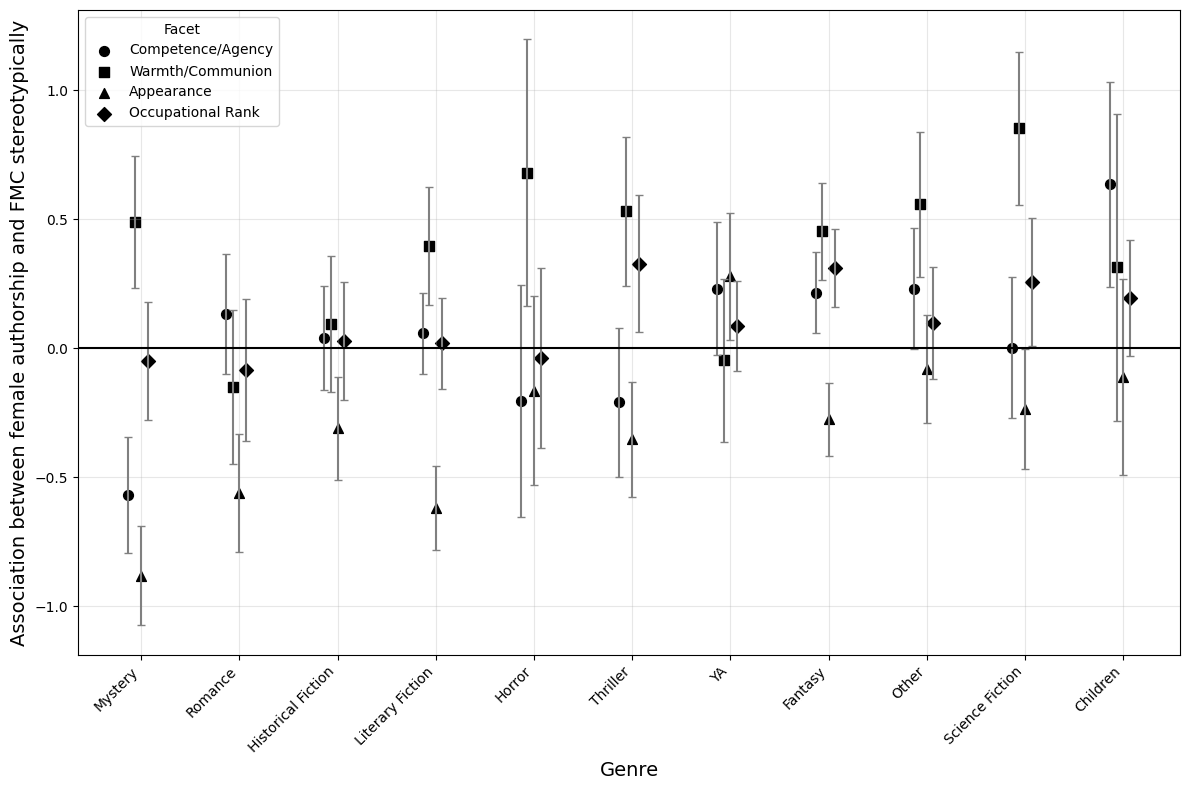

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plot
plt.figure(figsize=(12, 8))

# Unique blocks and markers for each
markers = ['o', 's', '^', 'D']
blocks = summary_df['Block'].unique()

# Compute sum of Gender_effect per genre and sort genres accordingly
genre_sums = summary_df.groupby('Genre')['Gender_effect'].sum().sort_values()
genres = genre_sums.index.tolist()  # Sorted genres by sum of Gender_effect

# Increase spacing between genres
genre_spacing = 3
genre_to_x = {genre: i * genre_spacing for i, genre in enumerate(genres)}

# Width of dodge (spread between blocks within each genre)
dodge_width = 0.2
offsets = [((i - len(blocks) / 2)) * dodge_width for i in range(len(blocks))]

# Plot each block manually with error bars
for i, block in enumerate(blocks):
    block_data = summary_df[summary_df['Block'] == block]
    
    for _, row in block_data.iterrows():
        genre = row['Genre']
        x = genre_to_x[genre] + offsets[i]
        y = row['Gender_effect']
        yerr_lower = y - row['CI_lower']
        yerr_upper = row['CI_upper'] - y
        
        # Plot point
        plt.scatter(x, y, marker=markers[i], s=50, color='black', label=block if x == genre_to_x[genres[0]] + offsets[i] else "")

        # Plot error bar
        plt.errorbar(x, y, yerr=[[yerr_lower], [yerr_upper]], fmt='none', ecolor='gray', capsize=3)

# Formatting x-axis
xticks = [genre_to_x[genre] for genre in genres]
plt.xticks(ticks=xticks, labels=genres, rotation=45, ha='right')

# Final touches
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Association between female authorship and FMC stereotypically', fontsize=14)
plt.axhline(y=0, color='black', linestyle='-')
plt.legend(title='Facet',  loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/Figure 6.png', dpi=300)
plt.show()


In [124]:
model_me_i = smf.ols('net_competence_agency ~ C(author_gender) * C(master_genre) + year', data=df_filtered).fit()
print(model_me_i.summary())

                              OLS Regression Results                             
Dep. Variable:     net_competence_agency   R-squared:                       0.065
Model:                               OLS   Adj. R-squared:                  0.063
Method:                    Least Squares   F-statistic:                     32.11
Date:                   Wed, 30 Jul 2025   Prob (F-statistic):          2.33e-130
Time:                           13:25:25   Log-Likelihood:                -18355.
No. Observations:                  10167   AIC:                         3.676e+04
Df Residuals:                      10144   BIC:                         3.692e+04
Df Model:                             22                                         
Covariance Type:               nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [120]:
df_filtered.columns

Index(['title', 'author', 'fmc_name', 'year', 'author_gender', 'master_genre',
       'Q4.answer', 'Q4.explanation', 'Q5.answer', 'Q5.explanation',
       'Q6.answer', 'Q6.explanation', 'Q7.answer', 'Q7.explanation',
       'Q8.answer', 'Q8.explanation', 'Q9.answer', 'Q9.explanation',
       'Q10.answer', 'Q10.explanation', 'Q11.answer', 'Q11.explanation',
       'Q12.answer', 'Q12.explanation', 'Q13.answer', 'Q13.explanation',
       'Q14.answer', 'Q14.explanation', 'Q15.answer', 'Q15.explanation',
       'Q16.answer', 'Q16.explanation', 'Q17.answer', 'Q17.explanation',
       'Q18.answer', 'Q18.explanation', 'Q19.answer', 'Q19.explanation',
       'Q20.answer', 'Q20.explanation', 'Q21.answer', 'Q21.explanation',
       'Q22.answer', 'Q22.explanation', 'Q23.answer', 'Q23.explanation',
       'Q24.answer', 'Q24.explanation', 'Q25.answer', 'Q25.explanation',
       'Q26.answer', 'Q26.explanation', 'Q27.answer', 'Q27.explanation',
       'Q28.answer', 'Q28.explanation', 'Q29.answer', 'Q2

In [ ]:
model_me_i = smf.ols('net_warmth_communal ~ C(author_gender) * C(master_genre) + year', data=df_filtered).fit()
print(model_me_i.summary())

In [ ]:
model_me_i = smf.ols('net_lower_rank ~ C(author_gender) * C(master_genre) + year', data=df_filtered).fit()
print(model_me_i.summary())

In [123]:
model_me_i = smf.ols('net_appearance ~ C(author_gender) * C(master_genre) + year', data=df_filtered).fit()
print(model_me_i.summary())

                            OLS Regression Results                            
Dep. Variable:         net_appearance   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     46.22
Date:                Wed, 30 Jul 2025   Prob (F-statistic):          4.88e-191
Time:                        13:24:31   Log-Likelihood:                -17588.
No. Observations:               10167   AIC:                         3.522e+04
Df Residuals:                   10144   BIC:                         3.539e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [92]:
# # ANOVA for easier reporting of categorical predictor results
# # Effect Sizes
# anova = pg.anova(
#     data=df_filtered,
#     dv='net_competence_agency',
#     between=['author_gender', 'master_genre'],
#     detailed=True
# )

# print(anova)

# # Effect size author gender: 0.000110
# # Effect size genre: 0.055991
# # Effect size author gender*genre: 0.005067

In [93]:
# # Author Gender - Plot

# plt.figure(figsize=(10, 6))
# sns.barplot(data=df_filtered, x='author_gender', y='net_competence_agency', palette='pastel', errorbar=('ci', 95))

# plt.title("Net Competence-Agency Rating per Author Gender")
# plt.ylabel("Net Competence-Agency Rating")
# plt.xlabel("Author Gender")
# plt.tight_layout()
# plt.show()

In [ ]:
# # Author Gender - Effect size

# # Subset the groups
# group_female_agency = df_filtered[df_filtered['author_gender'] == "Female"]['net_competence_agency']
# group_male_agency = df_filtered[df_filtered['author_gender'] == "Male"]['net_competence_agency']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female_agency, group_male_agency, eftype='cohen', paired=False)

# print("Cohen's d:", d)

Cohen's d: 0.12265778324157992


In [94]:
# # Genre ME - Neg - Plot

# # Calculate means and confidence intervals per group
# summary = df_filtered.groupby('master_genre')['net_competence_agency'].agg(['mean', 'count', 'std']).reset_index()
# summary['sem'] = summary['std'] / summary['count']**0.5
# summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# # Sort genres by mean for consistent ordering
# summary = summary.sort_values('mean', ascending=False)
# order = summary['master_genre']

# plt.figure(figsize=(10, 6))

# # Plot bars with seaborn, ordered by 'order'
# barplot = sns.barplot(data=df_filtered, 
#                       x='master_genre', 
#                       y='net_competence_agency', 
#                       order=order, 
#                       palette='pastel', 
#                       errorbar=('ci', 95))

# # Map bar colors to genres
# bar_colors = {}
# for patch in barplot.patches:
#     # x coordinate is the bar index
#     x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
#     bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# # Draw horizontal mean lines and two dashed lines for CI bounds
# for _, row in summary.iterrows():
#     genre = row['master_genre']
#     mean = row['mean']
#     ci = row['ci95']
#     color = bar_colors[genre]
    
#     # Lower CI bound dashed line
#     plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
#     # Upper CI bound dashed line
#     plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

# plt.title("Average Net Competence-Agency Rating per Genre")
# plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
# plt.ylabel("Net Competence-Agency Rating")
# plt.xlabel("Genre")
# plt.tight_layout()
# plt.show()

Competence Agency
Romance, historical fiction
fantasy, science fiction

In [95]:
# # ONLINE SUPPLEMENT ONLY
# # Genre ME - Significance Test 

# # Drop NA values to avoid errors
# df_clean = df_filtered[['master_genre', 'net_competence_agency']].dropna()

# # Perform Tukey HSD
# tukey = pairwise_tukeyhsd(endog=df_clean['net_competence_agency'],
#                           groups=df_clean['master_genre'],
#                           alpha=0.05)

# print(tukey.summary())



In [118]:
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

# # Calculate mean net_competence_agency for each genre and gender
# means_by_genre_gender = df_filtered.groupby(['master_genre', 'author_gender'])['net_competence_agency'].mean().unstack()

# # Sum male and female means for each genre
# genre_order = (means_by_genre_gender['Male'] + means_by_genre_gender['Female']).sort_values(ascending=False).index

# plt.figure(figsize=(12, 6))
# ax = sns.barplot(
#     data=df_filtered,
#     x='master_genre',
#     y='net_competence_agency',
#     hue='author_gender',
#     palette=gray_colors,
#     errorbar=('ci', 95),
#     order=genre_order
# )
# plt.xticks(rotation=45, ha='right')
# plt.ylabel("FMC stereotypicality (Competence-Agency)")
# plt.xlabel("Genre")
# plt.legend(title="Author Gender")
# plt.tight_layout()

# # Add significance stars for gender difference within each genre

# for i, genre in enumerate(genre_order):
#     genre_data = df_filtered[df_filtered['master_genre'] == genre]
#     tukey = pairwise_tukeyhsd(endog=genre_data['net_competence_agency'],
#                               groups=genre_data['author_gender'],
#                               alpha=0.05)
#     # Get p-value for Male vs Female
#     try:
#         pval = tukey.pvalues[0]
#     except Exception:
#         pval = np.nan
#     # Determine number of stars
#     if pval < 0.001:
#         stars = '***'
#     elif pval < 0.01:
#         stars = '**'
#     elif pval < 0.05:
#         stars = '*'
#     else:
#         stars = ''
#     # Get bar heights for annotation
#     means = genre_data.groupby('author_gender')['net_competence_agency'].mean()
#     y_max = means.max()
#     # Annotate above the bars
#     ax.text(i, y_max + 0.15, stars, ha='center', va='bottom', fontsize=16, color='black')

# plt.show()


In [117]:
# # ONLINE SUPPLEMENT ONLY
# # Interaction - Comp/agencey  - Significance Test

# df_clean = df_filtered[['master_genre', 'author_gender', 'net_competence_agency']].dropna()

# # Create interaction column
# df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# # Run Tukey's HSD
# tukey = pairwise_tukeyhsd(endog=df_clean['net_competence_agency'],
#                           groups=df_clean['interaction'],
#                           alpha=0.05)

# print(tukey.summary())

In [116]:
# # Author Gender*Genre - Comp/agencey - Effect size - Mystery

# # Subset the groups
# group_female_thriller = df_filtered[(df_filtered['author_gender'] == "Female") & (df_filtered['master_genre'] == "Mystery")]['net_competence_agency']
# group_male_thriller = df_filtered[(df_filtered['author_gender'] == "Male") & (df_filtered['master_genre'] == "Mystery")]['net_competence_agency']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female_thriller, group_male_thriller, eftype='cohen', paired=False)

# print("Cohen's d:", d)

In [115]:
# # Author Gender*Genre - Comp/agencey - Effect size - Fantasy

# # Subset the groups
# group_female_thriller = df_filtered[(df_filtered['author_gender'] == "Female") & (df_filtered['master_genre'] == "Fantasy")]['net_competence_agency']
# group_male_thriller = df_filtered[(df_filtered['author_gender'] == "Male") & (df_filtered['master_genre'] == "Fantasy")]['net_competence_agency']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female_thriller, group_male_thriller, eftype='cohen', paired=False)

# print("Cohen's d:", d)

##### Net Warmth-Communality

In [114]:
# # ANOVA for easier reporting of categorical predictor results
# # Effect Sizes
# anova = pg.anova(
#     data=df_filtered,
#     dv='net_warmth_communal',
#     between=['author_gender', 'master_genre'],
#     detailed=True
# )

# print(anova)

# # Effect size author gender: 0.007497
# # Effect size genre: 0.050913
# # Effect size author gender*genre: 0.003714

In [113]:
# # Genre ME - Neg - Plot

# # Calculate means and confidence intervals per group
# summary = df_filtered.groupby('master_genre')['net_warmth_communal'].agg(['mean', 'count', 'std']).reset_index()
# summary['sem'] = summary['std'] / summary['count']**0.5
# summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# # Sort genres by mean for consistent ordering
# summary = summary.sort_values('mean', ascending=False)
# order = summary['master_genre']

# plt.figure(figsize=(10, 6))

# # Plot bars with seaborn, ordered by 'order'
# barplot = sns.barplot(data=df_filtered, 
#                       x='master_genre', 
#                       y='net_warmth_communal', 
#                       order=order, 
#                       palette='pastel', 
#                       errorbar=('ci', 95))

# # Map bar colors to genres
# bar_colors = {}
# for patch in barplot.patches:
#     # x coordinate is the bar index
#     x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
#     bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# # Draw horizontal mean lines and two dashed lines for CI bounds
# for _, row in summary.iterrows():
#     genre = row['master_genre']
#     mean = row['mean']
#     ci = row['ci95']
#     color = bar_colors[genre]
    
#     # Lower CI bound dashed line
#     plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
#     # Upper CI bound dashed line
#     plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

# plt.title("Average Net Warmth-Communality Rating per Genre")
# plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
# plt.ylabel("Net Warmth-Communality Rating")
# plt.xlabel("Genre")
# plt.tight_layout()
# plt.show()

Warmth-Communality
Historical Fiction, Children 
Thriller, Mystery 

In [112]:
# # ONLINE SUPPLEMENT ONLY
# # Genre ME - Significance Test 

# # Drop NA values to avoid errors
# df_clean = df_filtered[['master_genre', 'net_warmth_communal']].dropna()

# # Perform Tukey HSD
# tukey = pairwise_tukeyhsd(endog=df_clean['net_warmth_communal'],
#                           groups=df_clean['master_genre'],
#                           alpha=0.05)

# print(tukey.summary())

# # Convert Tukey results to a DataFrame
# tukey_results = pd.DataFrame(
#     data=tukey._results_table.data[1:],  # Skip header
#     columns=tukey._results_table.data[0]  # Column names
# )
# tukey_results.to_latex('tukey_results.tex', index=False)

##### Net Appearance

In [111]:
# # ANOVA for easier reporting of categorical predictor results
# # Effect Sizes
# anova = pg.anova(
#     data=df_filtered,
#     dv='net_appearance',
#     between=['author_gender', 'master_genre'],
#     detailed=True
# )

# print(anova)

# # Effect size author gender: 0.007497
# # Effect size genre: 0.050913
# # Effect size author gender*genre: 0.003714

In [110]:
# # Genre ME - Neg - Plot

# # Calculate means and confidence intervals per group
# summary = df_filtered.groupby('master_genre')['net_appearance'].agg(['mean', 'count', 'std']).reset_index()
# summary['sem'] = summary['std'] / summary['count']**0.5
# summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# # Sort genres by mean for consistent ordering
# summary = summary.sort_values('mean', ascending=False)
# order = summary['master_genre']

# plt.figure(figsize=(10, 6))

# # Plot bars with seaborn, ordered by 'order'
# barplot = sns.barplot(data=df_filtered, 
#                       x='master_genre', 
#                       y='net_appearance', 
#                       order=order, 
#                       palette='pastel', 
#                       errorbar=('ci', 95))

# # Map bar colors to genres
# bar_colors = {}
# for patch in barplot.patches:
#     # x coordinate is the bar index
#     x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
#     bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# # Draw horizontal mean lines and two dashed lines for CI bounds
# for _, row in summary.iterrows():
#     genre = row['master_genre']
#     mean = row['mean']
#     ci = row['ci95']
#     color = bar_colors[genre]
    
#     # Lower CI bound dashed line
#     plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
#     # Upper CI bound dashed line
#     plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

# plt.title("Average Net Appearance Rating per Genre")
# plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
# plt.ylabel("Net Appearance Rating")
# plt.xlabel("Genre")
# plt.tight_layout()
# plt.show()

appearance
romance, historical fiction, literary fiction
mystery, science fiction, fantsay

In [109]:
# # ONLINE SUPPLEMENT ONLY
# # Genre ME - Significance Test 

# # Drop NA values to avoid errors
# df_clean = df_filtered[['master_genre', 'net_appearance']].dropna()

# # Perform Tukey HSD
# tukey = pairwise_tukeyhsd(endog=df_clean['net_appearance'],
#                           groups=df_clean['master_genre'],
#                           alpha=0.05)

# print(tukey.summary())

# # Convert Tukey results to a DataFrame
# tukey_results = pd.DataFrame(
#     data=tukey._results_table.data[1:],  # Skip header
#     columns=tukey._results_table.data[0]  # Column names
# )
# tukey_results.to_latex('tukey_results.tex', index=False)

In [108]:
# # Interaction - Plot

# plt.figure(figsize=(12, 6))

# sns.barplot(
#     data=df_filtered,
#     x='master_genre',
#     y='net_appearance',
#     hue='author_gender',
#     palette='pastel',
#     errorbar=('ci', 95),
# )

# plt.xticks(rotation=45, ha='right')
# plt.title("Net Appearance Rating by Gender and Genre", fontsize=14)
# plt.ylabel("Net Appearance Rating")
# plt.xlabel("Genre")
# plt.legend(title="Author Gender")
# plt.tight_layout()
# plt.show()

In [107]:
# # ONLINE SUPPLEMENT ONLY
# # Interaction - Appearance  - Significance Test

# df_clean = df_filtered[['master_genre', 'author_gender', 'net_appearance']].dropna()

# # Create interaction column
# df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# # Run Tukey's HSD
# tukey = pairwise_tukeyhsd(endog=df_clean['net_appearance'],
#                           groups=df_clean['interaction'],
#                           alpha=0.05)

# print(tukey.summary())

##### Lower Rank 

In [106]:
# # ANOVA for easier reporting of categorical predictor results
# # Effect Sizes
# anova = pg.anova(
#     data=df_filtered,
#     dv='net_lower_rank',
#     between=['author_gender', 'master_genre'],
#     detailed=True
# )

# print(anova)

# # Effect size author gender: 0.007497
# # Effect size genre: 0.050913
# # Effect size author gender*genre: 0.003714

In [105]:
# # Genre ME - Neg - Plot

# # Calculate means and confidence intervals per group
# summary = df_filtered.groupby('master_genre')['net_lower_rank'].agg(['mean', 'count', 'std']).reset_index()
# summary['sem'] = summary['std'] / summary['count']**0.5
# summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# # Sort genres by mean for consistent ordering
# summary = summary.sort_values('mean', ascending=False)
# order = summary['master_genre']

# plt.figure(figsize=(10, 6))

# # Plot bars with seaborn, ordered by 'order'
# barplot = sns.barplot(data=df_filtered, 
#                       x='master_genre', 
#                       y='net_lower_rank', 
#                       order=order, 
#                       palette='pastel', 
#                       errorbar=('ci', 95))

# # Map bar colors to genres
# bar_colors = {}
# for patch in barplot.patches:
#     # x coordinate is the bar index
#     x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
#     bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# # Draw horizontal mean lines and two dashed lines for CI bounds
# for _, row in summary.iterrows():
#     genre = row['master_genre']
#     mean = row['mean']
#     ci = row['ci95']
#     color = bar_colors[genre]
    
#     # Lower CI bound dashed line
#     plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
#     # Upper CI bound dashed line
#     plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

# plt.title("Average Rank Rating per Genre")
# plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
# plt.ylabel("Net Rank Rating")
# plt.xlabel("Genre")
# plt.tight_layout()
# plt.show()

Rank 
literary fiction, historical fiction
fantasy, mystery, thriller 

In [104]:
# # ONLINE SUPPLEMENT ONLY
# # Genre ME - Significance Test 

# # Drop NA values to avoid errors
# df_clean = df_filtered[['master_genre', 'net_lower_rank']].dropna()

# # Perform Tukey HSD
# tukey = pairwise_tukeyhsd(endog=df_clean['net_lower_rank'],
#                           groups=df_clean['master_genre'],
#                           alpha=0.05)

# print(tukey.summary())

# # Convert Tukey results to a DataFrame
# tukey_results = pd.DataFrame(
#     data=tukey._results_table.data[1:],  # Skip header
#     columns=tukey._results_table.data[0]  # Column names
# )
# tukey_results.to_latex('tukey_results.tex', index=False)

##### Appearance Focus Pos Only

In [103]:
# # ANOVA for easier reporting of categorical predictor results
# # Effect Sizes
# anova = pg.anova(
#     data=df_filtered,
#     dv='z_appearance_pos',
#     between=['author_gender', 'master_genre'],
#     detailed=True
# )

# print(anova)

# # Effect size author gender: 0.026562  
# # Effect size genre: 0.043701
# # Effect size author gender*genre: 0.005916

df_filtered['z_appearance_pos']

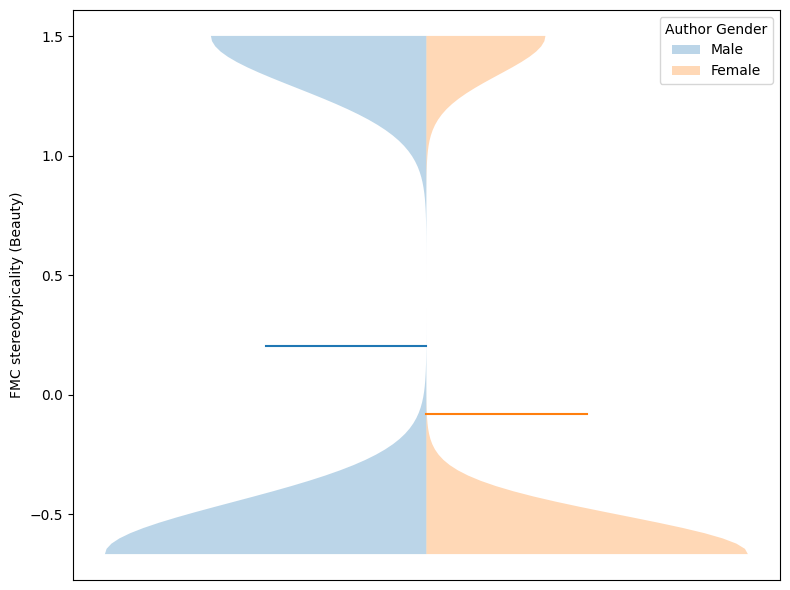

In [ ]:
# # Extract groups
# male_data = df_filtered[df_filtered['author_gender'] == 'Male']['z_appearance_pos']
# female_data = df_filtered[df_filtered['author_gender'] == 'Female']['z_appearance_pos']

# fig, ax = plt.subplots(figsize=(8, 6))

# v1 = ax.violinplot(
#     male_data,
#     positions=[0],
#     showmeans=True,
#     showmedians=False,
#     showextrema=False,
#     side='low'
# )

# v2 = ax.violinplot(
#     female_data,
#     positions=[0],
#     showmeans=True,
#     showmedians=False,
#     showextrema=False,
#     side='high'
# )

# # Axis labels
# ax.set_xticks([]) 
# ax.set_xticklabels([])
# ax.set_ylabel("FMC stereotypicality (Beauty)")

# from matplotlib.patches import Patch

# # Get actual colors from the violin objects
# male_color = v1['bodies'][0].get_facecolor().flatten()
# female_color = v2['bodies'][0].get_facecolor().flatten()

# legend_elements = [
#     Patch(facecolor=male_color, label='Male'),
#     Patch(facecolor=female_color, label='Female')
# ]

# ax.legend(handles=legend_elements, title='Author Gender')

# plt.tight_layout()
# plt.show()

In [102]:
# # Author Gender - Effect size

# # Subset the groups
# group_female_agency = df_filtered[df_filtered['author_gender'] == "Female"]['z_appearance_pos']
# group_male_agency = df_filtered[df_filtered['author_gender'] == "Male"]['z_appearance_pos']

# # Calculate Cohen's d
# d = pg.compute_effsize(group_female_agency, group_male_agency, eftype='cohen', paired=False)

# print("Cohen's d:", d)

In [101]:
# # ONLINE SUPPLEMENT ONLY
# # Gender ME - Significance Test 

# # Drop NA values to avoid errors
# df_clean = df_filtered[['author_gender', 'z_appearance_pos']].dropna()

# # Perform Tukey HSD
# tukey = pairwise_tukeyhsd(endog=df_clean['z_appearance_pos'],
#                           groups=df_clean['author_gender'],
#                           alpha=0.05)

# print(tukey.summary())

In [100]:
# Genre ME - Appearance pos - Plot

# Calculate means and confidence intervals per group
summary = df_filtered.groupby('master_genre')['z_appearance_pos'].agg(['mean', 'count', 'std']).reset_index()
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# Sort genres by mean for consistent ordering
summary = summary.sort_values('mean', ascending=False)
order = summary['master_genre']

# plt.figure(figsize=(10, 6))

# # Plot bars with seaborn, ordered by 'order'
# barplot = sns.barplot(data=df_filtered, 
#                       x='master_genre', 
#                       y='z_appearance_pos', 
#                       order=order, 
#                       palette='pastel', 
#                       errorbar=('ci', 95))

# Map bar colors to genres
# bar_colors = {}
# for patch in barplot.patches:
#     # x coordinate is the bar index
#     x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
#     bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# # Draw horizontal mean lines and two dashed lines for CI bounds
# for _, row in summary.iterrows():
#     genre = row['master_genre']
#     mean = row['mean']
#     ci = row['ci95']
#     color = bar_colors[genre]
    
#     # Lower CI bound dashed line
#     plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
#     # Upper CI bound dashed line
#     plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

# plt.title("Beauty-only Rating per Genre")
# plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
# plt.ylabel("FMC stereotypicality (Beauty)")
# plt.xlabel("Genre")
# plt.tight_layout()
# plt.show()

In [99]:
# # ONLINE SUPPLEMENT ONLY
# # Genre ME - Significance Test 

# # Drop NA values to avoid errors
# df_clean = df_filtered[['master_genre', 'z_appearance_pos']].dropna()

# # Perform Tukey HSD
# tukey = pairwise_tukeyhsd(endog=df_clean['z_appearance_pos'],
#                           groups=df_clean['master_genre'],
#                           alpha=0.05)

# print(tukey.summary())

/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_1524/1066036374.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = genre_data.groupby('author_gender')['z_appearance_pos'].mean()


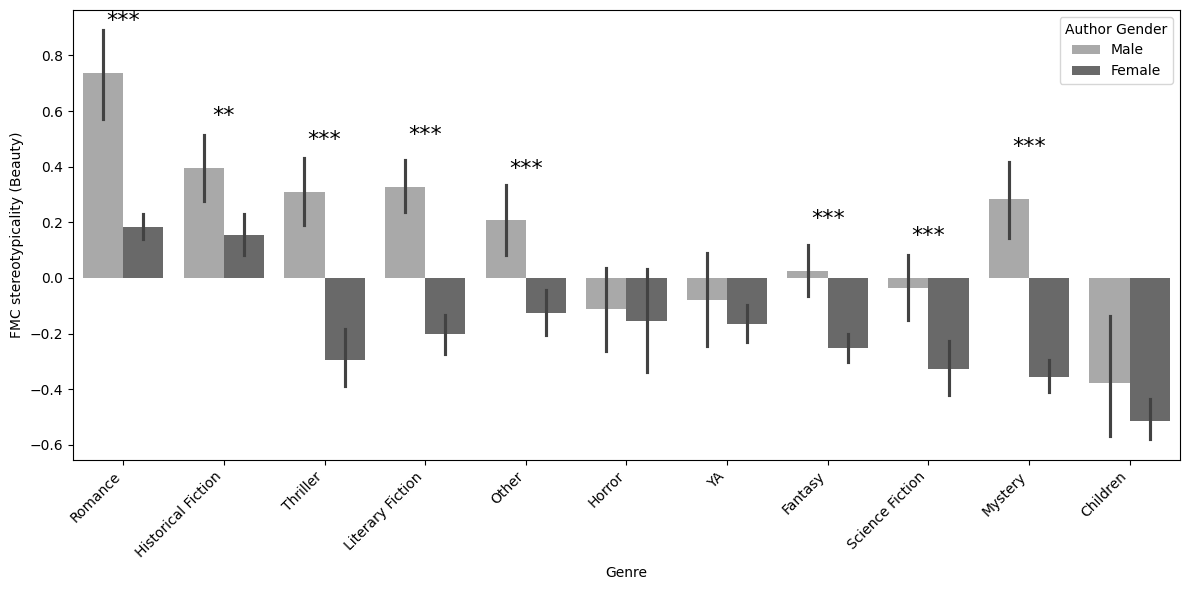

In [97]:
# order genres by their mean z_appearance_pos
means_by_genre = df_filtered.groupby('master_genre')['z_appearance_pos'].mean().sort_values(ascending=False)
genre_order = means_by_genre.index
plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data=df_filtered,
    x='master_genre',
    y='z_appearance_pos',
    hue='author_gender',
    palette=gray_colors,
    errorbar=('ci', 95),
    order=genre_order
)

plt.xticks(rotation=45, ha='right')
plt.ylabel("FMC stereotypicality (Beauty)")
plt.xlabel("Genre")
plt.legend(title="Author Gender")
plt.tight_layout()

# Add significance stars for gender difference within each genre
for i, genre in enumerate(genre_order):
    genre_data = df_filtered[df_filtered['master_genre'] == genre]
    tukey = pairwise_tukeyhsd(endog=genre_data['z_appearance_pos'],
                              groups=genre_data['author_gender'],
                              alpha=0.05)
    try:
        pval = tukey.pvalues[0]
    except Exception:
        pval = np.nan
    if pval < 0.001:
        stars = '***'
    elif pval < 0.01:
        stars = '**'
    elif pval < 0.05:
        stars = '*'
    else:
        stars = ''
    means = genre_data.groupby('author_gender')['z_appearance_pos'].mean()
    y_max = means.max()
    ax.text(i, y_max + 0.15, stars, ha='center', va='bottom', fontsize=16, color='black')

plt.savefig("../visualizations/Figure 7.png", dpi=300)
plt.show()

In [98]:
# # ONLINE SUPPLEMENT ONLY
# # Interaction - Comp/agencey  - Significance Test

# df_clean = df_filtered[['master_genre', 'author_gender', 'z_appearance_pos']].dropna()

# # Create interaction column
# df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# # Run Tukey's HSD
# tukey = pairwise_tukeyhsd(endog=df_clean['z_appearance_pos'],
#                           groups=df_clean['interaction'],
#                           alpha=0.05)

# print(tukey.summary())